In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### EDA

In [32]:
# Import the data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [33]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [34]:
df.shape

(5110, 12)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [36]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [37]:
df.loc[0]

id                              9046
gender                          Male
age                             67.0
hypertension                       0
heart_disease                      1
ever_married                     Yes
work_type                    Private
Residence_type                 Urban
avg_glucose_level             228.69
bmi                             36.6
smoking_status       formerly smoked
stroke                             1
Name: 0, dtype: object

#### Look at the class distribution -- it's very unbalanced

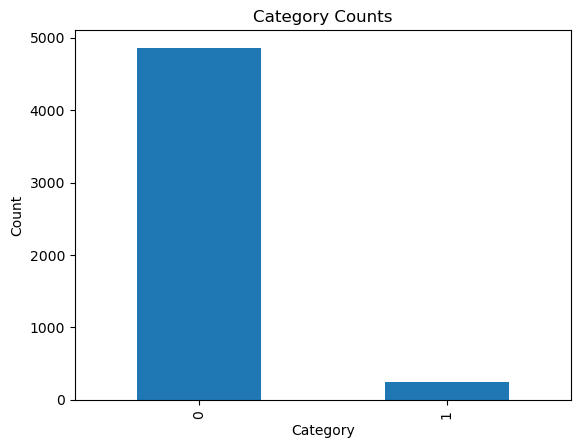

In [38]:
df.stroke.value_counts().plot.bar()
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.show()

#### Look at the distribution of each variable

C:\Users\jackm\AppData\Local\Temp\ipykernel_31548\267303913.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.drop(labels = ['id', 'stroke'], axis = 1).hist(ax = ax, color = 'forestgreen')


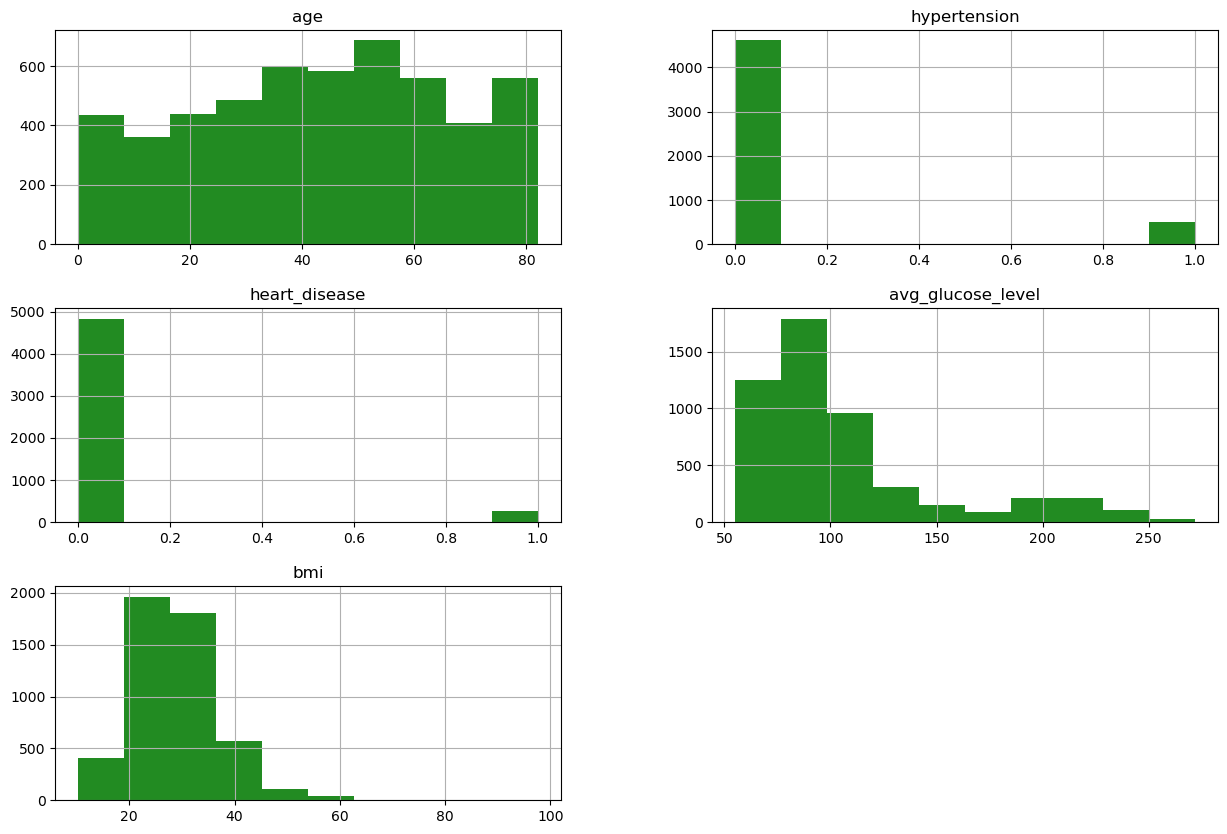

In [39]:
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()

df.drop(labels = ['id', 'stroke'], axis = 1).hist(ax = ax, color = 'forestgreen')
pass

#### Look at a correlation heatmap between each variable

<AxesSubplot: >

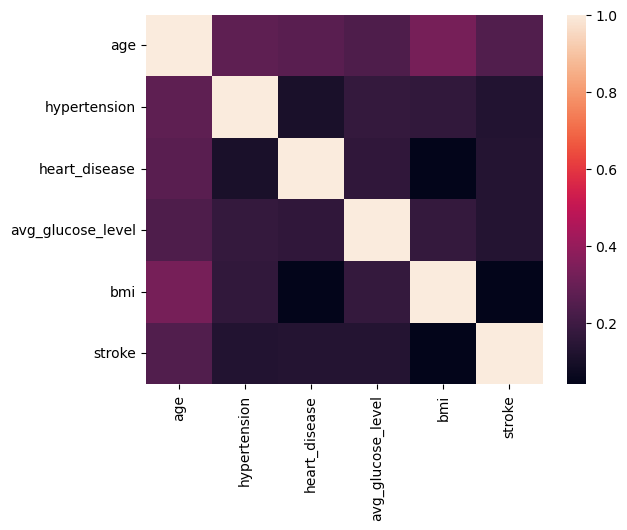

In [40]:
sns.heatmap(df.drop('id', axis = 1).corr())

#### Look at a pair plot to see relationships between variables

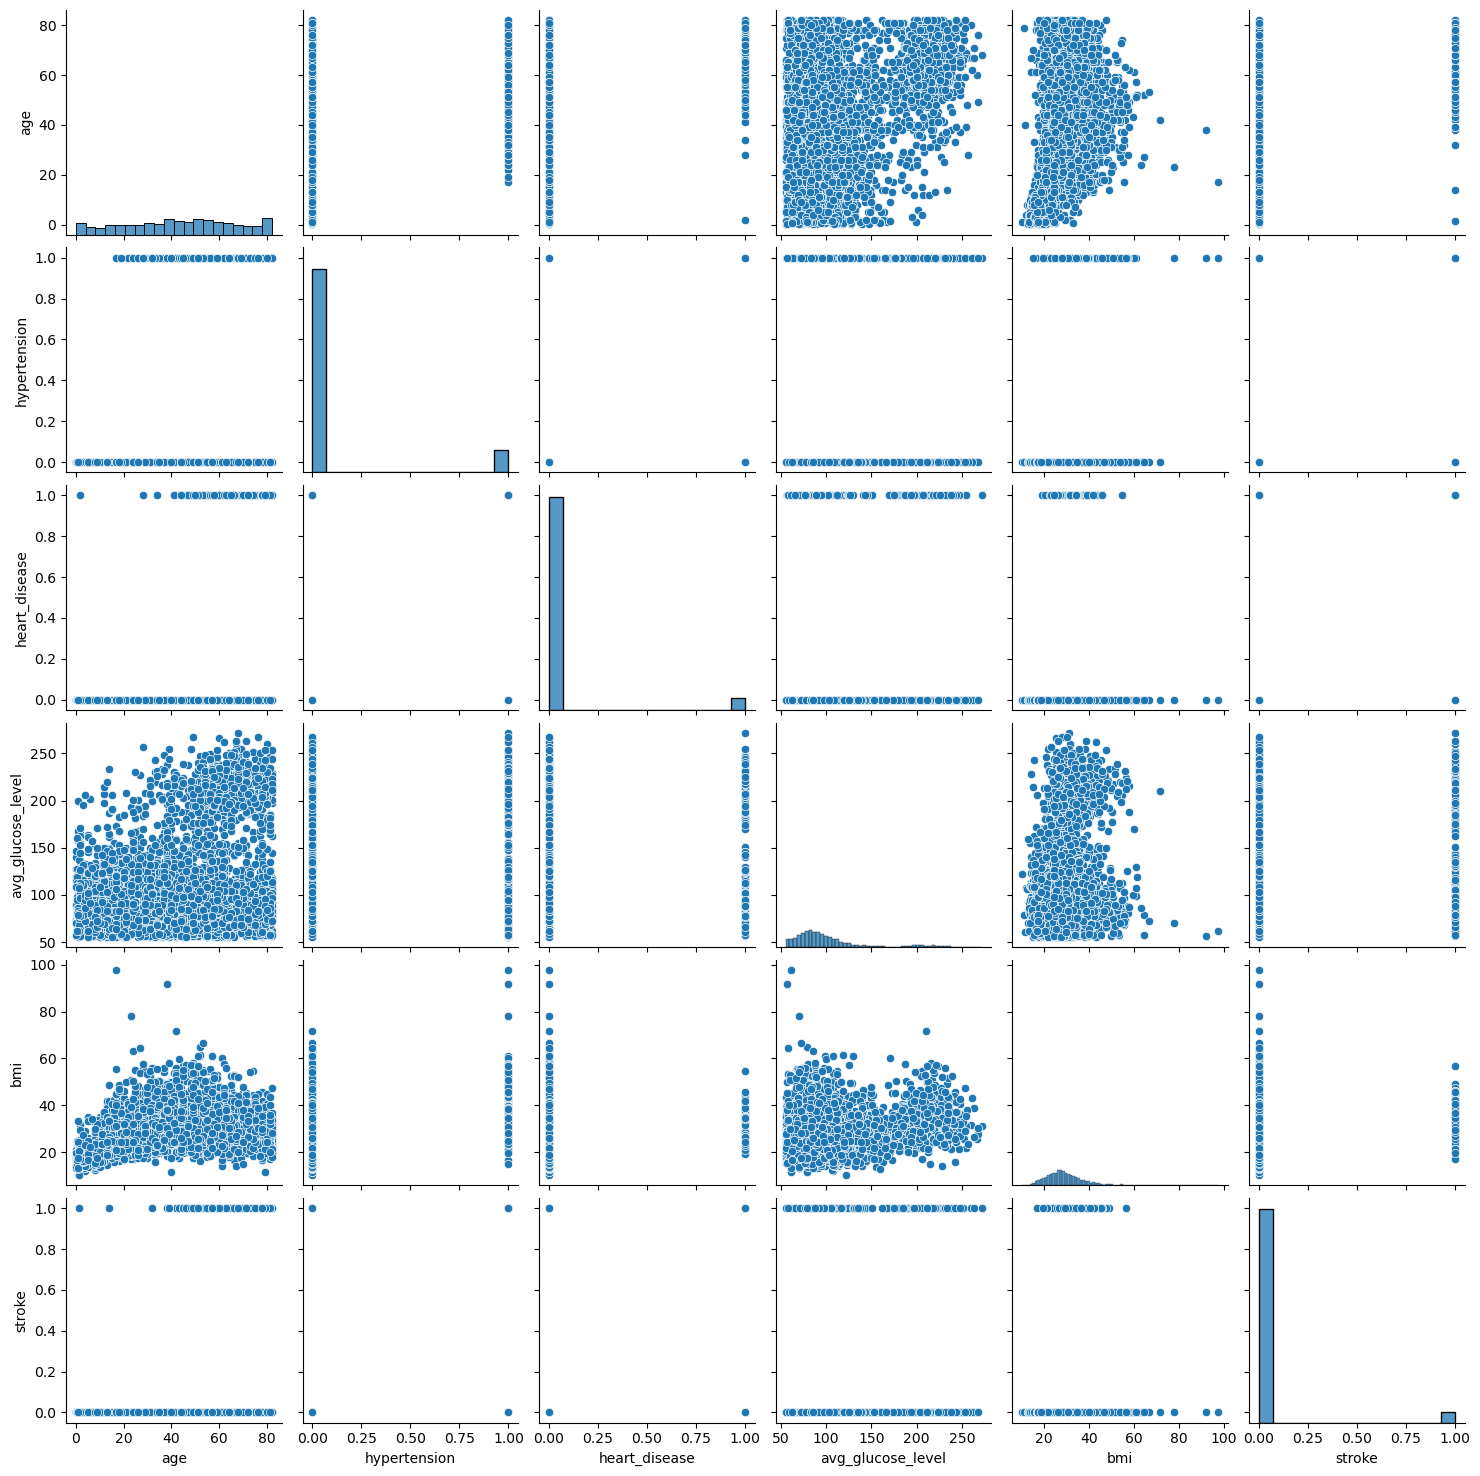

In [41]:
sns.pairplot(df.drop('id', axis = 1))

### Data Preprocessing

In [42]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

#### Look at the variable distribution among patients with no listed 'bmi'

C:\Users\jackm\AppData\Local\Temp\ipykernel_31548\2183565369.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[df['bmi'].isna()].drop('id', axis = 1).hist(ax = ax, color = 'forestgreen')


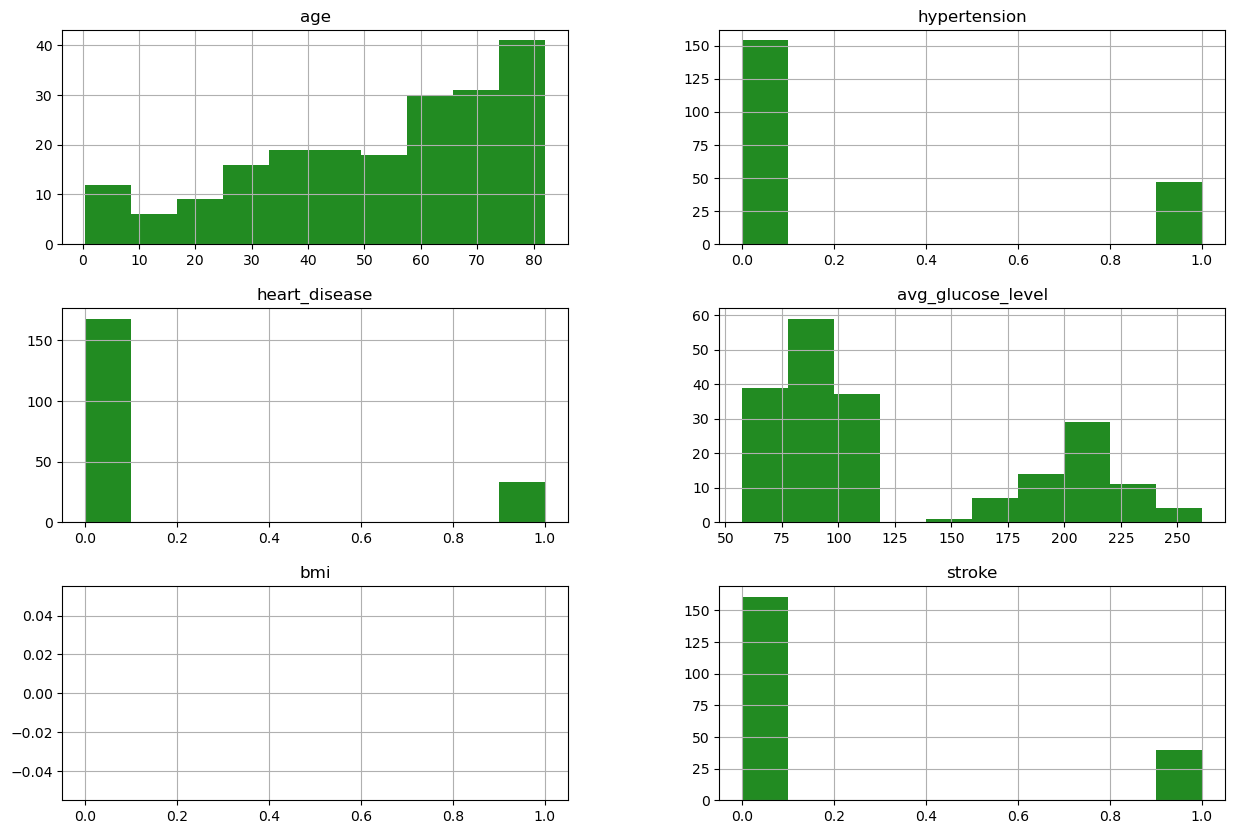

In [92]:
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()

df[df['bmi'].isna()].drop('id', axis = 1).hist(ax = ax, color = 'forestgreen')
pass

In [93]:
df.bmi.mean()

28.893236911794673

In [97]:
df = df.fillna(value = df.bmi.mean())
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [98]:
# Create X dataframe of predictors and a y dataframe of response
X = df.drop(labels = ['id', 'stroke'], axis = 1)
y = df['stroke']

In [99]:
# Get dummies for categorical predictors in X
X_encoded = pd.get_dummies(X)

In [100]:
X_encoded.shape

(5110, 21)

In [101]:
# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.25)

In [102]:
X_train.shape

(3832, 21)

In [103]:
X_test.shape

(1278, 21)

### Model 1: XGBoost - RandomizedSearchCV (before SMOTE)

#### Train a Model

In [104]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [105]:
xgb_clf = xgb.XGBClassifier(random_state = 33)

# Try different combinations of parameters
parameters = {'n_estimators': np.arange(100, 1050, 50).tolist(),
              'learning_rate': [round(num, 1) for num in np.arange(0.1, 1.7, 0.1).tolist()],
              'max_depth': [1, 2],
              'gamma': np.arange(0.0, 5.25, 0.25).tolist()
             }

In [106]:
clf_xg = RandomizedSearchCV(estimator = xgb_clf, param_distributions = parameters, scoring = 'roc_auc', cv = 5)

In [107]:
import time
st = time.time()

clf_xg.fit(X_train, y_train)

et = time.time()
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

Execution time: 0.3113750497500102 minutes


In [108]:
# See which parameters led to the best fit
print(clf_xg.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=1, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=950, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=33, ...)


#### Predict on Test Data

In [109]:
yhat_test_class_xg = clf_xg.best_estimator_.predict(X_test)
yhat_test_proba_xg = clf_xg.best_estimator_.predict_proba(X_test)

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc
cm_xg = confusion_matrix(y_test, yhat_test_class_xg)

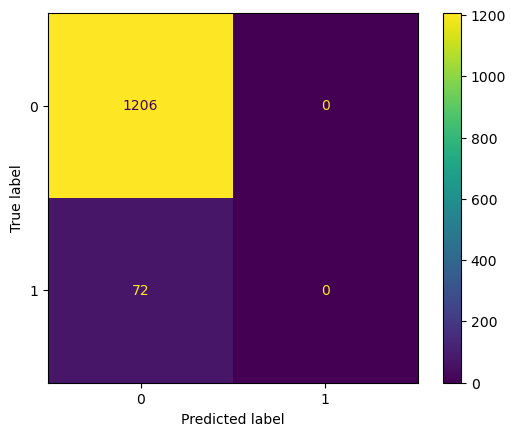

In [111]:
ConfusionMatrixDisplay(confusion_matrix = cm_xg, display_labels = clf_xg.classes_).plot()

In [112]:
print(classification_report(y_test, yhat_test_class_xg, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1206
           1       0.00      0.00      0.00        72

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.49      1278
weighted avg       0.89      0.94      0.92      1278



C:\Users\jackm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jackm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jackm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [113]:
print("AUC score =", roc_auc_score(y_test, yhat_test_proba_xg[:, 1]))

AUC score = 0.8432259996314723


In [114]:
yhat_test_proba_xg[:,1]

array([0.06055984, 0.06826109, 0.02535774, ..., 0.10865139, 0.10528007,
       0.00092762], dtype=float32)

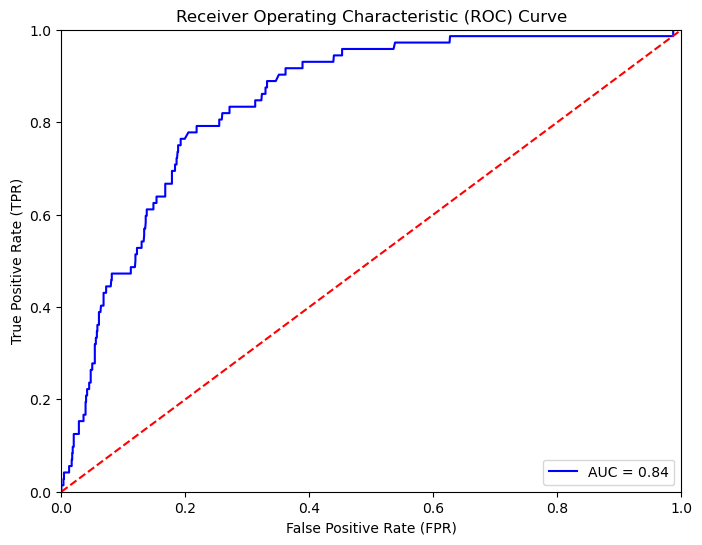

In [115]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, yhat_test_proba_xg[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [116]:
dist = np.sqrt(np.square(1 - tpr) + np.square(fpr))
best_threshold_idx = np.argmin(dist)
best_threshold = thresholds[best_threshold_idx]
best_threshold

0.06364885

### Model 2: Updated Threshold

In [117]:
yhat_new_threshold = (yhat_test_proba_xg[:,1] >= best_threshold).astype(int)

In [118]:
cm_xg_2 = confusion_matrix(y_test, yhat_new_threshold)

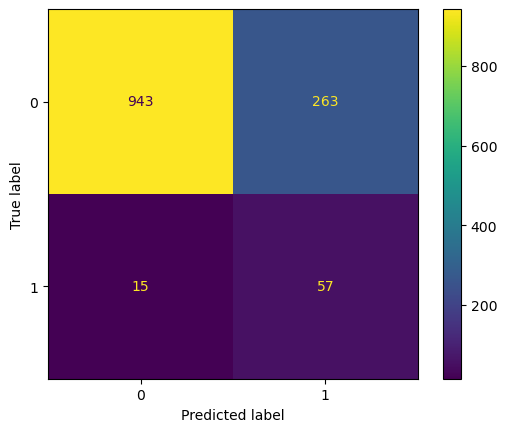

In [119]:
ConfusionMatrixDisplay(confusion_matrix = cm_xg_2, display_labels = clf_xg.classes_).plot()

In [120]:
print(classification_report(y_test, yhat_new_threshold, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1206
           1       0.18      0.79      0.29        72

    accuracy                           0.78      1278
   macro avg       0.58      0.79      0.58      1278
weighted avg       0.94      0.78      0.84      1278



In [121]:
print("AUC score =", roc_auc_score(y_test, yhat_test_proba_xg[:, 1]))

AUC score = 0.8432259996314723


In [122]:
feature_importance = pd.DataFrame(zip(X_test.columns, clf_xg.best_estimator_.feature_importances_), columns = ['feature', 'importance'])
top5_features = feature_importance.sort_values(by = 'importance', ascending = False).head(5).reset_index(drop = True)
top5_features

,feature,importance
0,age,0.483622
1,heart_disease,0.177971
2,work_type_Private,0.088206
3,avg_glucose_level,0.077287
4,hypertension,0.059038


#### Predict on Train Data

In [123]:
yhat_train_class_xg = clf_xg.best_estimator_.predict(X_train)
yhat_train_proba_xg = clf_xg.best_estimator_.predict_proba(X_train)

In [124]:
print(classification_report(y_train, yhat_train_class_xg, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3655
           1       0.00      0.00      0.00       177

    accuracy                           0.95      3832
   macro avg       0.48      0.50      0.49      3832
weighted avg       0.91      0.95      0.93      3832



C:\Users\jackm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jackm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jackm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Try Balancing the Dataset

In [146]:
# Current distribution of stroke vs no stroke
df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [147]:
# SMOTE
fraud_oversample = df[df['stroke'] == 1].sample(df[df['stroke'] == 0]['id'].count(), replace=True)
df_oversampled = pd.concat([df[df['stroke'] == 0], fraud_oversample], axis=0)

In [148]:
# Balanced distribution
df_oversampled['stroke'].value_counts(normalize=True)

0    0.5
1    0.5
Name: stroke, dtype: float64

In [149]:
# Create X dataframe of predictors and a y dataframe of response
X_bal = df_oversampled.drop(labels = ['id', 'stroke'], axis = 1)
y_bal = df_oversampled['stroke']

In [150]:
# Get dummies for categorical predictors in X
X_encoded_bal = pd.get_dummies(X_bal)

In [151]:
X_encoded_bal.shape

(9722, 21)

#### Train/Test Split

In [152]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_bal, y_bal, test_size = 0.25)

In [153]:
X_train.shape

(7291, 21)

In [154]:
X_test.shape

(2431, 21)

### Model 3: XGBoost - RandomizedSearchCV (after SMOTE)

#### Train a Model

In [155]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [156]:
xgb_clf = xgb.XGBClassifier(random_state = 33)

# Try different combinations of parameters
parameters = {'n_estimators': np.arange(100, 1050, 50).tolist(),
              'learning_rate': [round(num, 1) for num in np.arange(0.1, 1.7, 0.1).tolist()],
              'max_depth': [1, 2],
              'gamma': np.arange(0.0, 5.25, 0.25).tolist()
             }

In [157]:
clf_xg = RandomizedSearchCV(estimator = xgb_clf, param_distributions = parameters, scoring = 'roc_auc', cv = 5)

In [158]:
import time
st = time.time()

clf_xg.fit(X_train, y_train)

et = time.time()
res = et - st
final_res = res / 60
print('Execution time:', final_res, 'minutes')

Execution time: 0.4227345665295919 minutes


In [159]:
# See which parameters led to the best fit
print(clf_xg.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1.6, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=650, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=33, ...)


#### Predict on Test Data

In [160]:
yhat_test_class_xg = clf_xg.best_estimator_.predict(X_test)
yhat_test_proba_xg = clf_xg.best_estimator_.predict_proba(X_test)

In [161]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc
cm_xg = confusion_matrix(y_test, yhat_test_class_xg)

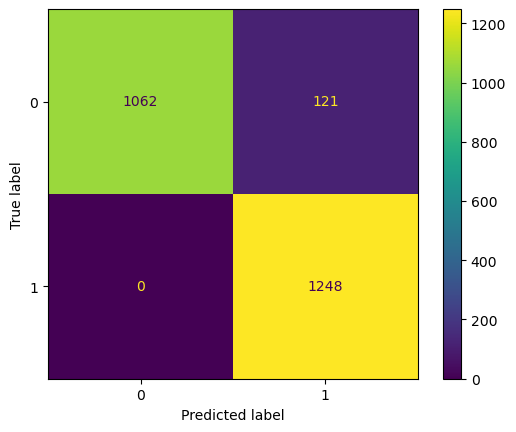

In [162]:
ConfusionMatrixDisplay(confusion_matrix = cm_xg, display_labels = clf_xg.classes_).plot()

In [163]:
print(classification_report(y_test, yhat_test_class_xg, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1183
           1       0.91      1.00      0.95      1248

    accuracy                           0.95      2431
   macro avg       0.96      0.95      0.95      2431
weighted avg       0.95      0.95      0.95      2431



In [164]:
print("AUC score =", roc_auc_score(y_test, yhat_test_proba_xg[:, 1]))

AUC score = 0.9667044617118582


In [165]:
yhat_test_proba_xg[:,1]

array([8.4479898e-01, 3.5371163e-01, 9.1394591e-01, ..., 3.0066358e-39,
       9.1007823e-01, 3.8802642e-01], dtype=float32)

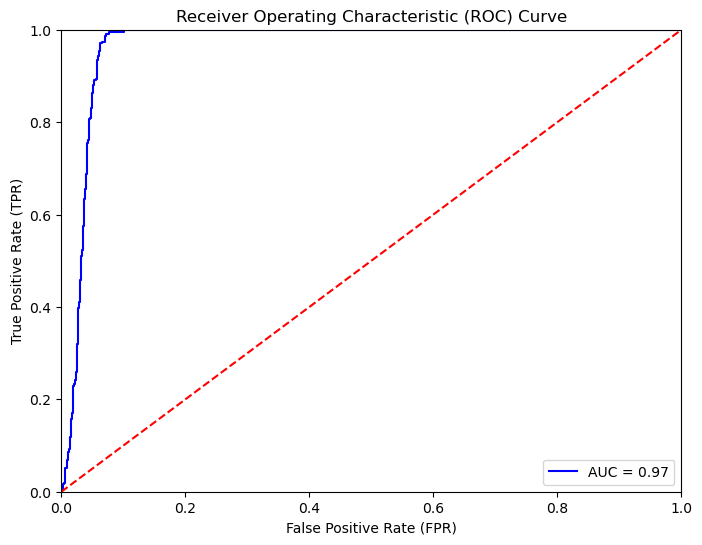

In [176]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, yhat_test_proba_xg[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [167]:
dist = np.sqrt(np.square(1 - tpr) + np.square(fpr))
best_threshold_idx = np.argmin(dist)
best_threshold = thresholds[best_threshold_idx]
best_threshold

0.72713995

In [168]:
yhat_new_threshold = (yhat_test_proba_xg[:,1] >= best_threshold).astype(int)

In [169]:
cm_xg_2 = confusion_matrix(y_test, yhat_new_threshold)

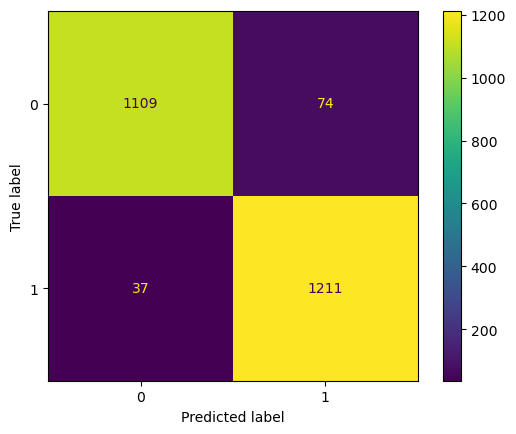

In [170]:
ConfusionMatrixDisplay(confusion_matrix = cm_xg_2, display_labels = clf_xg.classes_).plot()

In [171]:
print(classification_report(y_test, yhat_new_threshold, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1183
           1       0.94      0.97      0.96      1248

    accuracy                           0.95      2431
   macro avg       0.96      0.95      0.95      2431
weighted avg       0.95      0.95      0.95      2431



In [172]:
print("AUC score =", roc_auc_score(y_test, yhat_test_proba_xg[:, 1]))

AUC score = 0.9667044617118582


In [173]:
feature_importance = pd.DataFrame(zip(X_test.columns, clf_xg.best_estimator_.feature_importances_), columns = ['feature', 'importance'])
top5_features = feature_importance.sort_values(by = 'importance', ascending = False).head(5).reset_index(drop = True)
top5_features

,feature,importance
0,smoking_status_never smoked,0.308712
1,age,0.193394
2,smoking_status_formerly smoked,0.109778
3,smoking_status_smokes,0.074161
4,ever_married_No,0.060426


#### Predict on Train Data

In [174]:
yhat_train_class_xg = clf_xg.best_estimator_.predict(X_train)
yhat_train_proba_xg = clf_xg.best_estimator_.predict_proba(X_train)

In [175]:
print(classification_report(y_train, yhat_train_class_xg, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3678
           1       0.93      1.00      0.97      3613

    accuracy                           0.96      7291
   macro avg       0.97      0.96      0.96      7291
weighted avg       0.97      0.96      0.96      7291



In [74]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)